<a href="https://colab.research.google.com/github/shresthabhi/IIT_VT_capstone_project/blob/main/code/1)Capstone_Examiner_Level.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project

## Importing necessary Libraries

In [314]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from IPython.display import display, HTML
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

## Reading the data

In [168]:
## Reading the data files -

data_ex_art_level = pd.read_csv("https://raw.githubusercontent.com/shresthabhi/IIT_VT_capstone_project/main/data/examiner_art_level_data.csv")
data_ex_level = pd.read_csv("https://raw.githubusercontent.com/shresthabhi/IIT_VT_capstone_project/main/data/examiner_level_data.csv")
data_art_level = pd.read_csv("https://raw.githubusercontent.com/shresthabhi/IIT_VT_capstone_project/main/data/art_level_data.csv")

## Custom function used for data analysis

In [222]:
def get_info(data):
  """
    Input:
      data(pd.DataFrame)
    Output:
      DataFrame - Null value
  """
  null_count = pd.Series(data.isna().sum(), name = "null_count")
  non_null_count = pd.Series(data.notna().sum(), name = "not_null_count")
  unique_values = pd.Series(data.nunique(), name = "unique_values")
  total = data.shape[0]

  other_info = data.describe(include = "all").T

  for col in ["unique", "count"]:
    try:
      other_info.drop(columns = [col], inplace = True)
    except: KeyError

  df = pd.concat([null_count, non_null_count, unique_values, other_info], axis = 1)
  df["perct_null_count"] = df["null_count"]/total
  df["total"] = total


  return df[["total", "null_count", "not_null_count", "perct_null_count","unique_values"] + [*other_info.columns]]

def highlight_cells(val, threshold, color_if_true, color_if_false):
    """
    Returns pandas style compatible string
    Input:
      val           : value on which highlighting is to be don
      threshold     : threshold about which color is to be highlighted
      color-if_true : color if val >= threshold
      color_if_fale : color if val < threshold  
    """

    color = color_if_true if val >= threshold else color_if_false
    return 'background-color: {}'.format(color)

def plot_histogram(data, columns = None, exclude_columns = None, verbose = False, graph_size = 5):
  """
    Input:
      data            : pd.DataFrame
      columns         : columns for which histogram has to be ploted
      exclude_columns : columns to exclude from the plot
      verbose         : Print which graph is being processed
      graph_size      : factor, size of individual graphs
    Output:
      fig, ax
  """


  if(columns == None):
    columns = [*data.columns]
  
  if(exclude_columns != None):
    columns = [col for col in columns if col not in exclude_columns]


  total_columns = len(columns)
  n_cols = min(4, total_columns)
  n_rows = math.ceil(total_columns/4)

  fig, ax = plt.subplots(nrows = n_rows, ncols = n_cols, figsize = (n_cols*graph_size, n_rows*graph_size), squeeze = False)

  # if(verbose):
  #   print(total_columns, n_cols, n_rows)

  for index, col in enumerate(columns):

    ax_row_position = index//n_cols
    ax_col_position = index%n_cols

    if(verbose):
      print(index, col, ax_row_position, ax_col_position)

    sns.histplot(data = data, x = col, ax = ax[ax_row_position, ax_col_position])
    
    if(col[:5] == "perct"):
      ax[ax_row_position, ax_col_position].set_xlim(0,1)  
  plt.show()

  return fig, ax

def get_mean_variance(data, cols):
  """
    Returns mean and standard deviation of the data
  """
  return data[cols].mean(), data[cols].std()




## Exploratory Analysis

### Checking for examiner and total application

In [171]:
data_ex_level[["examiner_name", "total_application"]].groupby(by = "examiner_name").sum().reset_index().sort_values(by = "total_application", ascending = False)

,examiner_name,total_application
1391,"CENTRAL, DOCKET",324157
1594,"CHILCOT, RICHARD E",7359
387,"ANWAR, KHAWAJA",7230
8342,"SHIELDS, RHEA M",6566
7408,"PRATT, MICHAEL AARON",5979
...,...,...
3111,"GLASSER, BRIAN ISSAC",1
10023,"WRZESINSKI, ERIC CHARLES",1
7773,"ROBINSON, ELIZABETH A",1
3090,"GILLIS, BRIAN J",1


**Takeaways from above histogram**
1.   Removing CENTRAL, DOCKET from data as it seems to be an outlier

In [212]:
data_ex_level_1 = data_ex_level[data_ex_level.examiner_name != "CENTRAL, DOCKET"].copy()

In [172]:
## Checking data
data_info = get_info(data_ex_level_1)

In [183]:
data_info.style.format()\
            .background_gradient(subset=['perct_null_count'], cmap='YlOrRd')\
            .applymap(highlight_cells, subset=['unique_values'], threshold = 100, color_if_true = "#FDF9F9", color_if_false = "#E69BA3")

# display(HTML(data_info.style.format()\
#             .background_gradient(subset=['perct_null_count'], cmap='YlOrRd')\
#             .applymap(highlight_cells, subset=['unique_values'], threshold = 100, color_if_true = "#FDF9F9", color_if_false = "#E69BA3").render()))

,total,null_count,not_null_count,perct_null_count,unique_values,top,freq,mean,std,min,25%,50%,75%,max
examiner_name,10356,1,10355,0.000097,10355,"JACOBS-BURTON, LASHONDA T",1,nan,nan,nan,nan,nan,nan,nan
allowance_rate,10356,439,9917,0.042391,4673,nan,nan,0.713178,0.269161,0.000000,0.580645,0.807692,0.916667,1.000000
action_per_allowance,10356,843,9513,0.081402,5604,nan,nan,1.515878,0.644047,0.000000,1.072100,1.459596,1.896104,6.000000
average_months_to_first_action,10356,56,10300,0.005407,8698,nan,nan,16.699480,5.153191,1.000000,13.169612,16.398198,19.800450,43.571429
average_days_to_first_action,10356,56,10300,0.005407,10063,nan,nan,500.471680,154.575222,34.000000,394.763580,491.384314,593.441761,1309.000000
average_months_to_allowance,10356,843,9513,0.081402,7725,nan,nan,22.897776,6.561105,1.000000,18.425926,22.593220,27.000000,61.000000
average_days_to_allowance,10356,843,9513,0.081402,9236,nan,nan,686.424547,196.856715,29.000000,552.330882,677.413333,808.640625,1822.000000
perct_appeal_after_final_rejection_abandon,10356,618,9738,0.059676,2885,nan,nan,inf,nan,0.000000,0.078125,0.192982,0.392091,inf
perct_rce_after_final_rejection_abandon,10356,704,9652,0.067980,2318,nan,nan,0.428265,0.203760,0.000000,0.322034,0.452381,0.566667,1.000000
perct_ptab_affirmed,10356,8187,2169,0.790556,16,nan,nan,0.530969,0.458466,0.000000,0.000000,0.500000,1.000000,1.000000


**Takeaways from above table**
1.   Calculation of following metrics may not be correct - perct_affirmend_after_noa, perct_affirmend_after_noa, ptab_decision_application, ptab_affirmed_application, affirmed_after_noa_application, reversed_after_noa_application


0 allowance_rate 0 0
1 action_per_allowance 0 1
2 average_months_to_first_action 0 2
3 average_days_to_first_action 0 3
4 average_months_to_allowance 1 0
5 average_days_to_allowance 1 1
6 perct_appeal_after_final_rejection_abandon 1 2
7 perct_rce_after_final_rejection_abandon 1 3
8 perct_ptab_affirmed 2 0
9 n_ptab_action_per_ptab_application 2 1
10 perct_affirmend_after_noa 2 2
11 perct_reversed_after_noa 2 3
12 total_application 3 0
13 allowed_application 3 1
14 abandoned_application 3 2
15 n_non_final_rejection_action 3 3
16 n_final_rejection_action 4 0
17 n_exparte_quale_action 4 1
18 n_restriction_action 4 2
19 n_non_final_rejection_action_allow_application 4 3
20 n_final_rejection_action_allow_application 5 0
21 n_exparte_quale_action_allow_application 5 1
22 n_restriction_action_allow_application 5 2
23 non_final_rejection_application 5 3
24 final_rejection_application 6 0
25 exparte_quale_action_application 6 1
26 restrition_application 6 2
27 non_final_rejection_allowed_applica

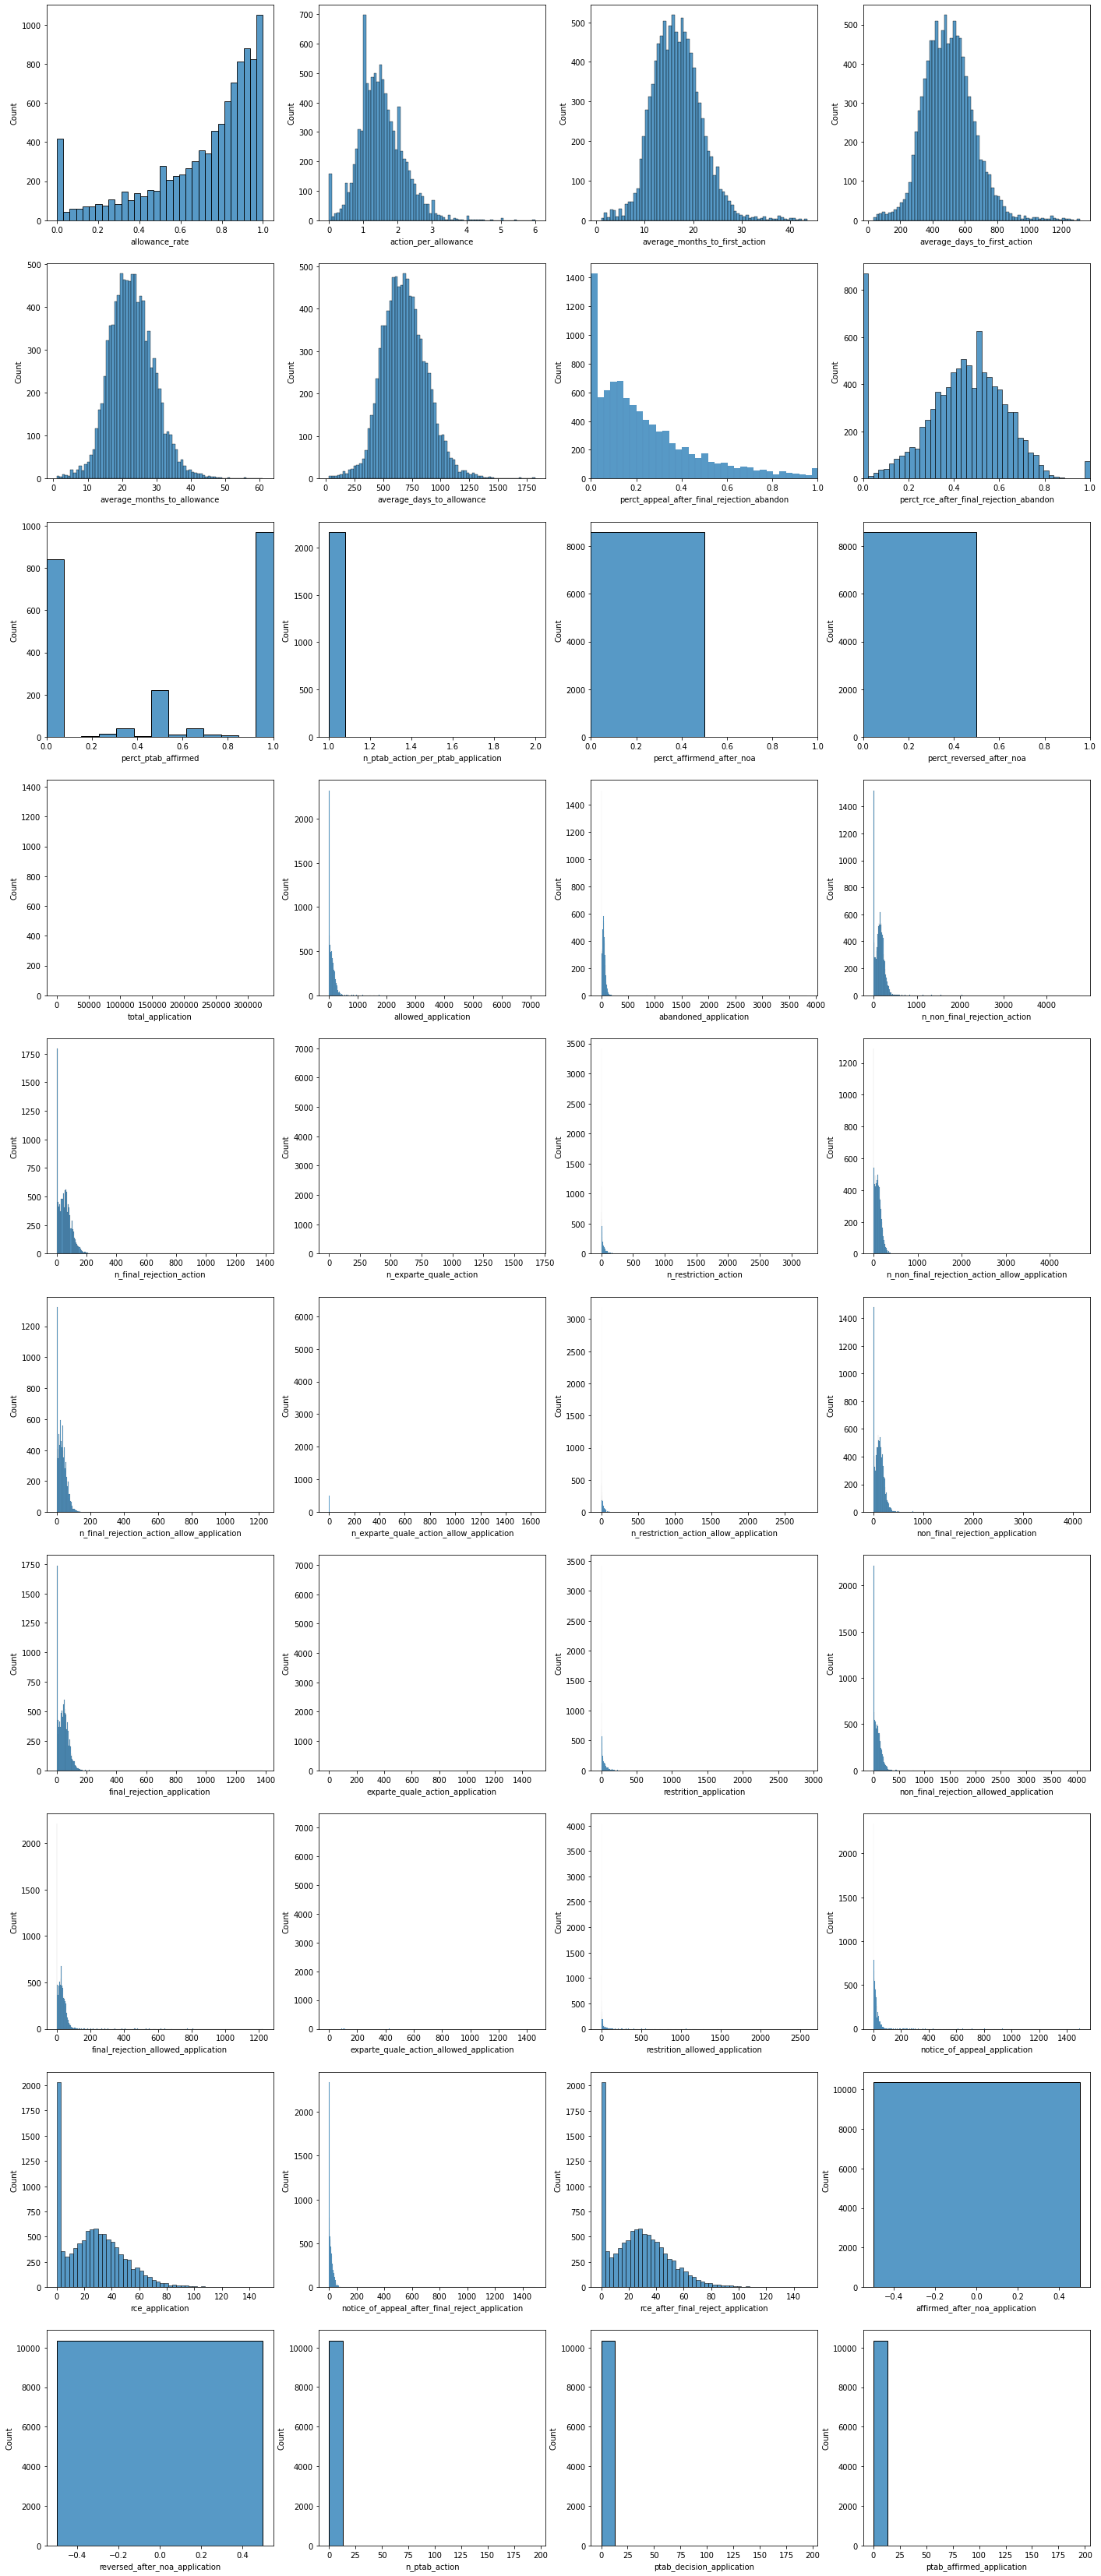

In [174]:
fig, ax = plot_histogram(data_ex_level, exclude_columns = ["examiner_name"], verbose = True, graph_size = 6)

**Takeaways from above histogram**
1.   Peak is observed around 0 allowance rate. This might be the examiner with less number of application and hence their allowance rate is low


## Feature Selection, data cleaning & transformation

In [297]:
train_columns = ["allowance_rate", "action_per_allowance", "average_days_to_first_action", "average_days_to_allowance"\
                 , "perct_appeal_after_final_rejection_abandon", "perct_rce_after_final_rejection_abandon"\
                 , "perct_ptab_affirmed", "n_ptab_action_per_ptab_application", "total_application"]

train_data = data_ex_level_1[train_columns].copy()

train_data_info = get_info(train_data)

train_data_info.style.format()\
            .background_gradient(subset=['perct_null_count'], cmap='YlOrRd')\
            .applymap(highlight_cells, subset=['unique_values'], threshold = 100, color_if_true = "#FDF9F9", color_if_false = "#E69BA3")


,total,null_count,not_null_count,perct_null_count,unique_values,mean,std,min,25%,50%,75%,max
allowance_rate,10356,439,9917,0.042391,4673,0.713178,0.269161,0.000000,0.580645,0.807692,0.916667,1.000000
action_per_allowance,10356,843,9513,0.081402,5604,1.515878,0.644047,0.000000,1.072100,1.459596,1.896104,6.000000
average_days_to_first_action,10356,56,10300,0.005407,10063,500.471680,154.575222,34.000000,394.763580,491.384314,593.441761,1309.000000
average_days_to_allowance,10356,843,9513,0.081402,9236,686.424547,196.856715,29.000000,552.330882,677.413333,808.640625,1822.000000
perct_appeal_after_final_rejection_abandon,10356,618,9738,0.059676,2885,inf,nan,0.000000,0.078125,0.192982,0.392091,inf
perct_rce_after_final_rejection_abandon,10356,704,9652,0.067980,2318,0.428265,0.203760,0.000000,0.322034,0.452381,0.566667,1.000000
perct_ptab_affirmed,10356,8187,2169,0.790556,16,0.530969,0.458466,0.000000,0.000000,0.500000,1.000000,1.000000
n_ptab_action_per_ptab_application,10356,8187,2169,0.790556,5,1.001114,0.026583,1.000000,1.000000,1.000000,1.000000,2.000000
total_application,10356,0,10356,0.000000,680,178.355736,292.419133,1.000000,63.000000,144.000000,228.000000,8296.000000


In [298]:
train_data = train_data[train_data.total_application >= 50].copy()

In [299]:
data_clean = train_data.copy()

data_cleaning = {"allowance_rate" : "drop_na_values",\
                 "action_per_allowance" : "mean",\
                 "average_days_to_first_action" : "mean",\
                 "average_days_to_allowance" : "mean",\
                 "perct_appeal_after_final_rejection_abandon" : "mean",\
                 "perct_rce_after_final_rejection_abandon" : "mean",\
                 "perct_ptab_affirmed" : "drop_columns",\
                 "n_ptab_action_per_ptab_application" : "drop_columns",\
                 "total_application" : "drop_columns"
                }


for key, value in data_cleaning.items():
  
  if(value == "drop_na_values"):
    data_clean = data_clean.dropna(subset = [key])
  elif(value == "mean"):
    mean_value = data_clean[key].mean()
    data_clean[key].fillna(mean_value, inplace = True)
  elif(value == "drop_columns"):
    data_clean.drop(columns = key, inplace = True)


## Replacing inf values
data_clean = data_clean.replace([np.inf, -np.inf], 0)
  
train_data = data_clean.copy()

del data_clean


In [300]:
train_data_info = get_info(train_data)
train_columns = train_data.columns

train_data_info.style.format()\
            .background_gradient(subset=['perct_null_count'], cmap='YlOrRd')\
            .applymap(highlight_cells, subset=['unique_values'], threshold = 100, color_if_true = "#FDF9F9", color_if_false = "#E69BA3")



,total,null_count,not_null_count,perct_null_count,unique_values,mean,std,min,25%,50%,75%,max
allowance_rate,8111,0,8111,0.000000,4651,0.752135,0.214974,0.000000,0.642857,0.822581,0.915254,1.000000
action_per_allowance,8111,0,8111,0.000000,5523,1.563826,0.602008,0.015789,1.140625,1.495238,1.921102,6.000000
average_days_to_first_action,8111,0,8111,0.000000,8094,489.288712,126.686573,107.250000,394.817043,483.020492,573.485475,1154.744681
average_days_to_allowance,8111,0,8111,0.000000,8052,690.549625,178.065063,132.000000,561.638838,677.824645,803.189904,1694.000000
perct_appeal_after_final_rejection_abandon,8111,0,8111,0.000000,2883,0.375584,1.025503,0.000000,0.107143,0.218391,0.412023,42.400000
perct_rce_after_final_rejection_abandon,8111,0,8111,0.000000,2298,0.461865,0.163304,0.000000,0.365653,0.471264,0.575111,1.000000


In [301]:
transform_columns = ["action_per_allowance", "average_days_to_first_action", "average_days_to_allowance"]

transformed_columns = ["tr_"+col for col in transform_columns]

standard_scaler = StandardScaler()
transformed_data = standard_scaler.fit_transform(train_data[transform_columns])

train_data.loc[:,transformed_columns] = transformed_data

final_columns = [col for col in train_columns if col not in transform_columns] + transformed_columns

train_data = train_data[final_columns].copy()

In [302]:
train_data.head()

,allowance_rate,perct_appeal_after_final_rejection_abandon,perct_rce_after_final_rejection_abandon,tr_action_per_allowance,tr_average_days_to_first_action,tr_average_days_to_allowance
0,0.931915,0.428571,0.404762,-0.891120,-1.014507,-1.125187
1,0.215686,0.035088,0.684211,2.083747,1.404971,2.747354
2,0.996942,0.096296,0.000000,-0.102631,-0.022288,0.497255
3,0.861607,0.188976,0.496063,0.707362,-0.047558,-0.113433
4,0.488889,0.072072,0.540541,1.202803,0.425833,0.598790


In [327]:
train_data_info = get_info(train_data)
train_columns = train_data.columns

train_data_info.style.format()\
            .background_gradient(subset=['perct_null_count'], cmap='YlOrRd')\
            .applymap(highlight_cells, subset=['unique_values'], threshold = 100, color_if_true = "#FDF9F9", color_if_false = "#E69BA3")


,total,null_count,not_null_count,perct_null_count,unique_values,mean,std,min,25%,50%,75%,max
allowance_rate,8111,0,8111,0.000000,4651,0.752135,0.214974,0.000000,0.642857,0.822581,0.915254,1.000000
perct_appeal_after_final_rejection_abandon,8111,0,8111,0.000000,2883,0.375584,1.025503,0.000000,0.107143,0.218391,0.412023,42.400000
perct_rce_after_final_rejection_abandon,8111,0,8111,0.000000,2298,0.461865,0.163304,0.000000,0.365653,0.471264,0.575111,1.000000
tr_action_per_allowance,8111,0,8111,0.000000,5523,-0.000000,1.000062,-2.571612,-0.703025,-0.113939,0.593510,7.369411
tr_average_days_to_first_action,8111,0,8111,0.000000,8094,0.000000,1.000062,-3.015807,-0.745758,-0.049481,0.664648,5.253098
tr_average_days_to_allowance,8111,0,8111,0.000000,8052,0.000000,1.000062,-3.136966,-0.723998,-0.071467,0.632618,5.635649


### Unsupervised model

#### 1) TSNE

In [313]:
model = TSNE(learning_rate = 10)
data_tsne = model.fit_transform(train_data)
x = data_tsne[:,0]
y = data_tsne[:,1]  

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


<AxesSubplot:>

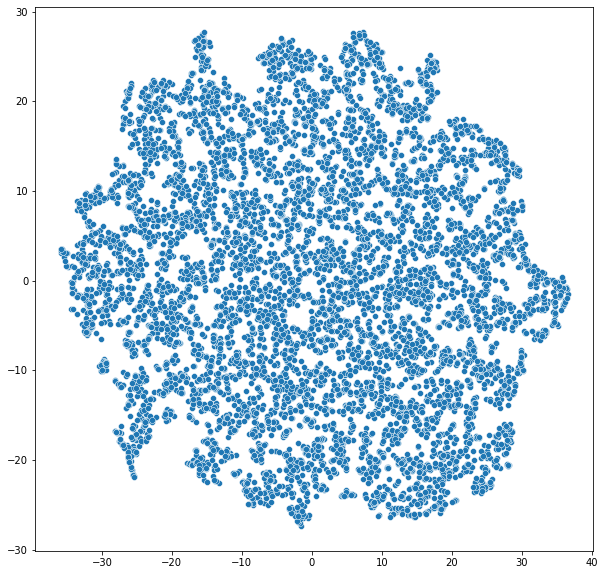

In [315]:
fig, ax = plt.subplots(figsize = (10,10))

sns.scatterplot(x=x, y=y, ax = ax)

In [316]:
model = TSNE(learning_rate = 100)
data_tsne = model.fit_transform(train_data)
x = data_tsne[:,0]
y = data_tsne[:,1]  

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


<AxesSubplot:>

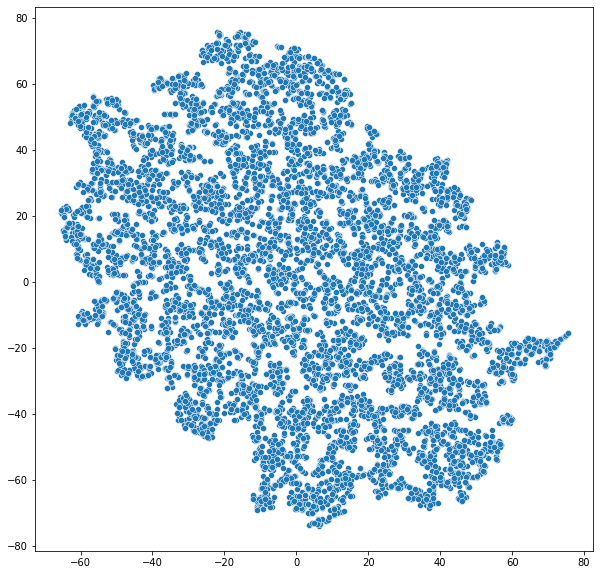

In [317]:
fig, ax = plt.subplots(figsize = (10,10))

sns.scatterplot(x=x, y=y, ax = ax)

In [318]:
model = TSNE(learning_rate = 200)
data_tsne = model.fit_transform(train_data)
x = data_tsne[:,0]
y = data_tsne[:,1]  

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


<AxesSubplot:>

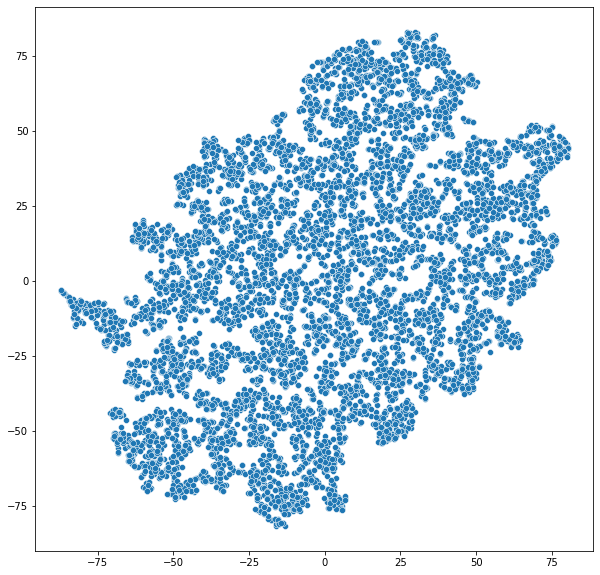

In [319]:
fig, ax = plt.subplots(figsize = (10,10))

sns.scatterplot(x=x, y=y, ax = ax)

In [320]:
model = TSNE(learning_rate = 500)
data_tsne = model.fit_transform(train_data)
x = data_tsne[:,0]
y = data_tsne[:,1]  

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


<AxesSubplot:>

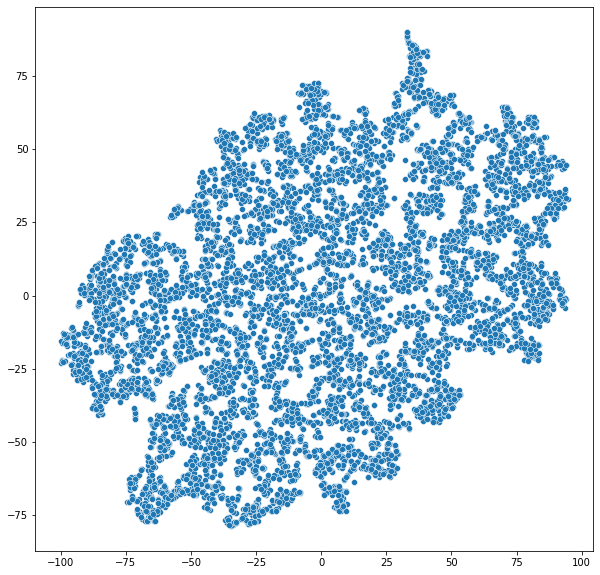

In [321]:
fig, ax = plt.subplots(figsize = (10,10))

sns.scatterplot(x=x, y=y, ax = ax)

In [322]:
model = TSNE(learning_rate = 750)
data_tsne = model.fit_transform(train_data)
x = data_tsne[:,0]
y = data_tsne[:,1]  

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


<AxesSubplot:>

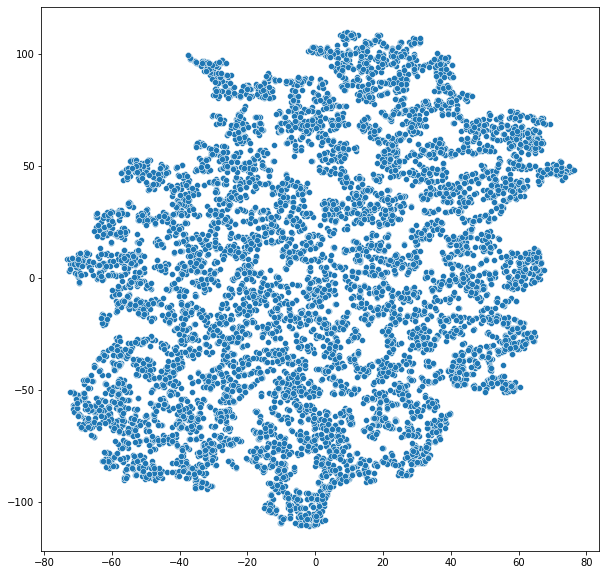

In [323]:
fig, ax = plt.subplots(figsize = (10,10))

sns.scatterplot(x=x, y=y, ax = ax)

In [324]:
model = TSNE(learning_rate = 1000)
data_tsne = model.fit_transform(train_data)
x = data_tsne[:,0]
y = data_tsne[:,1]  

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


<AxesSubplot:>

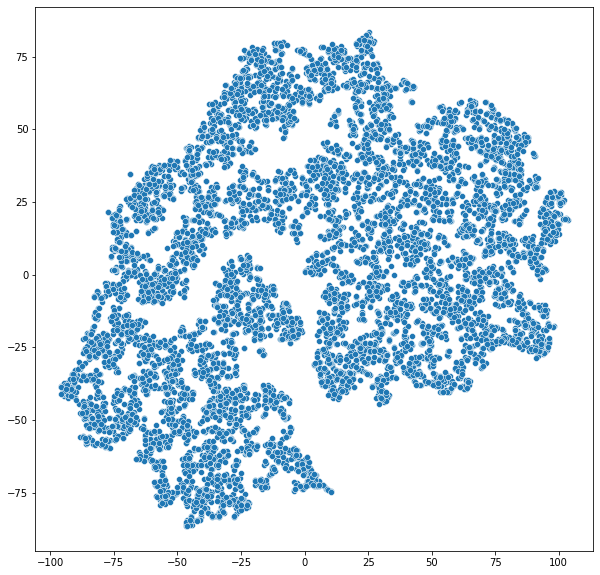

In [325]:
fig, ax = plt.subplots(figsize = (10,10))

sns.scatterplot(x=x, y=y, ax = ax)

#### 2) KMeans

In [328]:
n_cluster = 10
intertias = []
models = []


for n in range(1,n_cluster+1):

  model = KMeans(n_clusters = n)
  model.fit(train_data)
  models.append(model)
  intertias.append(model.inertia_)

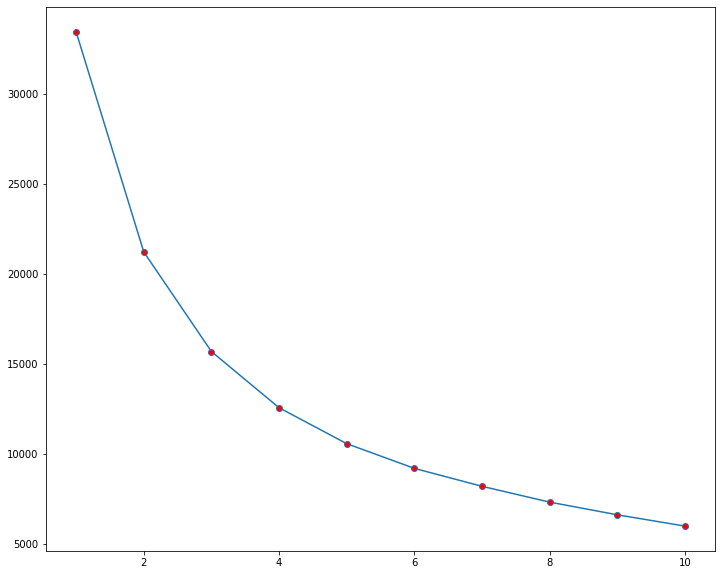

In [334]:
fig, ax = plt.subplots(figsize = (12,10))

plt.plot([*range(1,n_cluster+1)], intertias, marker = 'o', markerfacecolor = "red")

**Takeaways**<br>
An elbow occurs near number of cluster 4 and 5

In [338]:
model = KMeans(n_clusters = 4)
model.fit(train_data)

centres = model.cluster_centers_

results = pd.DataFrame(centres, columns = train_data.columns)

In [339]:
results.head()

,allowance_rate,perct_appeal_after_final_rejection_abandon,perct_rce_after_final_rejection_abandon,tr_action_per_allowance,tr_average_days_to_first_action,tr_average_days_to_allowance
0,0.767024,0.264053,0.464434,-0.028573,0.110102,0.040999
1,0.528719,0.114690,0.506763,1.043862,1.053847,1.310174
2,0.994980,24.000210,0.000000,-1.801753,-0.654437,-1.236870
3,0.902817,0.632958,0.425807,-0.755672,-0.950998,-1.053959


## Appendix

**Deduping application filing dates**
```
create table app_filing_dates_data as 

select app_num_value
    , cast(app_filing_date as date) as app_filing_date
from (
    select app_num_value
        , min(app_filing_date) as app_filing_date
    from abhinav_peds_data
    group by 1
)
```

**Calculating indicators for different processes**
```
drop table if exists app_indicators;

create table app_indicators as

select a.app_num_value
    , max(case when code = 'N/=.' then 1 else 0 end) as ind_accepted
    , max(case when regexp_like(code, '^ABN\d*') then 1 else 0 end) as ind_abandoned
    , max(case when code = 'CTNF' then 1 else 0 end) as ind_non_final_rejection
    , max(case when code = 'CTFR' then 1 else 0 end) as ind_final_rejection
    , max(case when code = 'CTEQ' then 1 else 0 end) as ind_exparte_quale_action
    , max(case when code = 'CTRS' then 1 else 0 end) as ind_restriction
    , max(case when code = 'CNOA' then 1 else 0 end) as ind_notice_of_appeal
    
    , count(distinct case when code = 'CTNF' then date end) as n_non_final_rejection_action
    , count(distinct case when code = 'CTFR' then date end) as n_final_rejection_action
    , count(distinct case when code = 'CTEQ' then date end) as n_exparte_quale_action
    , count(distinct case when code = 'CTRS' then date end) as n_restriction_action
    
    , count(distinct case when code in ('APDA','APDP','APDR','APDS') then date end) as n_ptab_action
    
    
    , max(case when code in ('APDA','APDP','APDR','APDS') then 1 else 0 end) as ind_ptab_action_filed
    , max(case when code in ('APDA') then 1 else 0 end) as ind_ptab_affirmed
    
    
    , max(case when code = 'RCEX' then 1 else 0 end) as ind_rce_filed
from abhinav_peds_data as a
group by 1
```


**RCE, Notice of Apppeal and PTAB Affirmation, Reversed**
```
drop table if exists peds_data.rce_noa_after_final_reject_data;

create table peds_data.rce_noa_after_final_reject_data as

with main_data as (

    select distinct
        app_num_value
        , min(case when code = 'RCEX' then date end) as first_RCEX_date
        , max(case when code = 'RCEX' then date end) as last_RCEX_date
        , min(case when code in ('CTFR', 'N/=.') or regexp_like(code, '^ABN\d*') then date end) as first_final_response_date
        , max(case when code in ('CTFR', 'N/=.') or regexp_like(code, '^ABN\d*') then date end) as last_final_response_date
        , min(case when code = 'CNOA' then date end) as first_CNOA_date
        , max(case when code = 'CNOA' then date end) as last_CNOA_date
        , min(case when code in ('APDA') then date end) as first_ptab_affirmed_date
        , max(case when code in ('APDA') then date end) as last_ptab_affirmed_date
        , min(case when code in ('APDR') then date end) as first_ptab_reversed_date
        , max(case when code in ('APDR') then date end) as last_ptab_reversed_date
        
        
    from abhinav_peds_data
    where code in ('RCEX', 'CTFR', 'CNOA', 'N/=.') or regexp_like(code, '^ABN\d*')
    group by 1
)

select app_num_value
    , case when last_CNOA_date >= first_final_response_date then 1 else 0 end as ind_appeal_after_final_rejection
    , case when last_RCEX_date >= first_final_response_date then 1 else 0 end as ind_rce_after_final_rejection
    , case when last_ptab_affirmed_date >= first_CNOA_date then 1 else 0 end as ind_affirmed_after_noa
    , case when last_ptab_reversed_date >= first_CNOA_date then 1 else 0 end as ind_reversed_after_noa
from main_data
```


**Date to first action and allowance**
```
drop table if exists date_to_first_action;

create table date_to_first_action as

select app_num_value
, cast(first_action_date as date) as first_action_date
, cast(allowance_date as date) as allowance_date
from (
    select app_num_value
        , min(date) as first_action_date
        , min(case when code = 'N/=.' then date end) as allowance_date
    from abhinav_peds_data
    where code in ('CTNF', 'CTFR' , 'CTEQ', 'CTRS', 'N/=.')
        or regexp_like(code, '^ABN\d*')
    group by 1
)
```

**Examiner X Art Unit level data**


```
drop table if exists peds_data.final_metrics;

create table peds_data.final_metrics as 

with main_data as (
    
    select distinct app_num_value
        , app_group_art_value
        , examiner_name
    from abhinav_peds_data
)

select app_group_art_value
    , examiner_name
    , count(case when ind_accepted = 1 then app_num_value end)*1.00000/count(case when ind_abandoned = 1 or ind_accepted = 1 then app_num_value end) as allowance_rate
    
    , sum(case when ind_accepted = 1 then coalesce(n_non_final_rejection_action,0)+ coalesce(n_final_rejection_action,0) + coalesce(n_exparte_quale_action,0) + coalesce(n_restriction_action,0) end)*1.00000/count(case when ind_accepted = 1 then app_num_value end) as action_per_allowance
    
    , avg(round(date_diff('day', app_filing_date, first_action_date)*1.0000/30)) as average_months_to_first_action
    , avg(date_diff('day', app_filing_date, first_action_Date)) as average_days_to_first_action
    
    , avg(round(date_diff('day', app_filing_date, allowance_date)*1.0000/30)) as average_months_to_allowance
    , avg(date_diff('day', app_filing_date, allowance_date)) as average_days_to_allowance
    
    , count(case when ind_appeal_after_final_rejection = 1 then app_num_value end)*1.00000/count(case when ind_abandoned =  1 or ind_final_rejection = 1 then app_num_value end) 
        as perct_appeal_after_final_rejection_abandon
    , count(case when ind_rce_after_final_rejection = 1 then app_num_value end)*1.00000/count(case when ind_abandoned =  1 or ind_final_rejection = 1 then app_num_value end) as perct_rce_after_final_rejection_abandon  
    
    , count(case when ind_ptab_affirmed = 1 then app_num_value end)*1.00000/count(case when ind_ptab_action_filed = 1 then app_num_value end) as perct_ptab_affirmed
    , sum(coalesce(n_ptab_action,0))*1.00000/count(case when ind_ptab_action_filed = 1 then app_num_value end) as n_ptab_action_per_ptab_application
    , count(case when ind_affirmed_after_noa = 1 then app_num_value end)*1.00000/count(case when ind_notice_of_appeal = 1 then app_num_value end) as perct_affirmed_after_noa
    , count(case when ind_reversed_after_noa = 1 then app_num_value end)*1.00000/count(case when ind_notice_of_appeal = 1 then app_num_value end) as perct_reversed_after_noa
    
    
    , count(app_num_value) as total_application
    , count(case when ind_accepted = 1 then app_num_value end) as allowed_application
    , count(case when ind_abandoned = 1 then app_num_value end) as abandoned_application
    
    , sum(coalesce(n_non_final_rejection_action,0)) as n_non_final_rejection_action
    , sum(coalesce(n_final_rejection_action,0)) as n_final_rejection_action
    , sum(coalesce(n_exparte_quale_action,0)) as n_exparte_quale_action
    , sum(coalesce(n_restriction_action,0)) as n_restriction_action
    
    , sum(case when ind_accepted = 1 then coalesce(n_non_final_rejection_action,0) end) as n_non_final_rejection_action_allow_application
    , sum(case when ind_accepted = 1 then coalesce(n_final_rejection_action,0) end) as n_final_rejection_action_allow_application
    , sum(case when ind_accepted = 1 then coalesce(n_exparte_quale_action,0) end) as n_exparte_quale_action_allow_application
    , sum(case when ind_accepted = 1 then coalesce(n_restriction_action,0) end) as n_restriction_action_allow_application
    
    , count(case when ind_non_final_rejection = 1 then app_num_value end) as non_final_rejection_application
    , count(case when ind_final_rejection = 1 then app_num_value end) as final_rejection_application
    , count(case when ind_exparte_quale_action = 1 then app_num_value end) as exparte_quale_action_application
    , count(case when  ind_restriction= 1 then app_num_value end) as restrition_application
    
    , count(case when ind_accepted = 1 and ind_non_final_rejection = 1 then app_num_value end) as non_final_rejection_allowed_application
    , count(case when ind_accepted = 1 and ind_final_rejection = 1 then app_num_value end) as final_rejection_allowed_application
    , count(case when ind_accepted = 1 and ind_exparte_quale_action = 1 then app_num_value end) as exparte_quale_action_allowed_application
    , count(case when ind_accepted = 1 and ind_restriction= 1 then app_num_value end) as restrition_allowed_application
    
    , count(case when ind_notice_of_appeal = 1 then app_num_value end) as notice_of_appeal_application
    , count(case when ind_rce_filed = 1 then app_num_value end) as rce_application
    , count(case when ind_appeal_after_final_rejection = 1 then app_num_value end) as notice_of_appeal_after_final_reject_application
    , count(case when ind_rce_after_final_rejection = 1 then app_num_value end) as rce_after_final_reject_application
    , count(case when ind_affirmed_after_noa = 1 then app_num_value end) as affirmed_after_noa_application
    , count(case when ind_reversed_after_noa = 1 then app_num_value end) as reversed_after_noa_application
    
    , sum(coalesce(n_ptab_action,0)) as n_ptab_action
    , count(case when ind_ptab_action_filed = 1 then app_num_value end) as ptab_decision_application
    , count(case when ind_ptab_affirmed = 1 then app_num_value end) as ptab_affirmed_application
    
from (
    select a.app_num_value
        , a.app_group_art_value
        , a.examiner_name
        , a0.app_filing_date
        , b.ind_accepted
        , b.ind_abandoned
        , b.ind_non_final_rejection
        , b.ind_final_rejection
        , b.ind_exparte_quale_action
        , b.ind_restriction
        , b.ind_notice_of_appeal
        , b.ind_ptab_action_filed
        , b.ind_ptab_affirmed
        , b.ind_rce_filed
        
        , b.n_non_final_rejection_action
        , b.n_final_rejection_action
        , b.n_exparte_quale_action
        , b.n_restriction_action
        
        , b.n_ptab_action
        
        , c.first_action_date
        , c.allowance_date
        
        , d.ind_appeal_after_final_rejection
        , d.ind_rce_after_final_rejection
        , d.ind_affirmed_after_noa
        , d.ind_reversed_after_noa
    
    from main_data as a
        left join app_filing_dates_data as a0 on a.app_num_value = a0.app_num_value
        left join app_indicators as b on a.app_num_value = b.app_num_value
        left join date_to_first_action as c on a.app_num_value = c.app_num_value
        left join rce_noa_After_final_reject_data as d on a.app_num_value = d.app_num_value
)
group by 1,2
```










